In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import pytorch3d.transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
from collections import namedtuple
Intrinsics = namedtuple('Intrinsics', ['height', 'width', 'fx', 'fy', 'cx', 'cy', 'near', 'far'])


In [4]:
intrinsics = Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=2.5
)
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


/var/tmp/ipykernel_1048622/2742540929.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


In [6]:
def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]

/var/tmp/ipykernel_867996/2905861234.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((100,3))*0.2 + torch.tensor([[0.0, 0.0, 1.0]]),device=device)
/var/tmp/ipykernel_867996/2905861234.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)


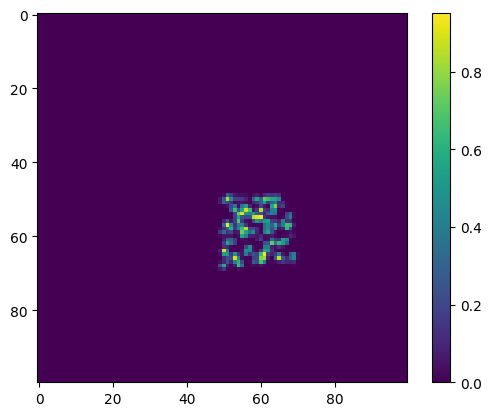

In [31]:

camera_pose = jnp.eye(4)
view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose))),0,1).cuda()
raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([0.0, 0.0, 0.0]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=view_matrix @ proj_matrix,
    sh_degree=1,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)

means3D = torch.tensor(torch.rand((100,3))*0.2 + torch.tensor([[0.0, 0.0, 1.0]]),device=device)
N = means3D.shape[0]
means2D = torch.ones((N, 3),requires_grad=True, device=device)
opacity = torch.rand((N, 1),requires_grad=True,device=device)
scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)
rotations = torch.rand((N, 4),requires_grad=True,device=device)

colors_precomp = means3D[:,2:3].repeat(1,3)

data = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = opacity,
    scales = scales,
    rotations = rotations
)

color, radii, num_rendered, tiles_depth_sorted,gaussian_sorted,tensor_ranges,out_weights=  data
depth_image = np.moveaxis(color.detach().cpu().numpy(),0,-1)[...,2]

out_weights = out_weights.detach().cpu().numpy()
tensor_ranges = tensor_ranges.detach().cpu().numpy()
gaussian_sorted = gaussian_sorted.detach().cpu().numpy()
colors_precomp = colors_precomp.detach().cpu().numpy()
plt.imshow(depth_image)
plt.colorbar()


In [1]:
BLOCK_X = 16
BLOCK_Y = 16
BLOCK_SIZE = BLOCK_X* BLOCK_Y
num_tiles_x = int((intrinsics.width + BLOCK_X - 1) / BLOCK_X)
num_tiles_y = int((intrinsics.height + BLOCK_Y - 1) / BLOCK_Y)
num_tiles = num_tiles_x * num_tiles_y


# Print all relevant info.

assert tensor_ranges.shape[0] == num_tiles * 2
num_gaussians = gaussian_sorted.shape[0]
assert out_weights.shape[0] == num_gaussians * BLOCK_X* BLOCK_Y

img = np.zeros((intrinsics.height, intrinsics.width))


for tile in tqdm(range(num_tiles)):
    range_x, range_y = tensor_ranges[2*tile], tensor_ranges[2*tile + 1]
    start_index = (BLOCK_SIZE * range_x)
    num_gaussians_in_this_block = range_y - range_x
    for ii in range(BLOCK_X):
        for jj in range(BLOCK_Y):
            pixel_coordinates = tile // num_tiles_y * BLOCK_Y + jj, tile % num_tiles_x * BLOCK_X + ii
            if pixel_coordinates[0] >= intrinsics.height or pixel_coordinates[1] >= intrinsics.width:
                continue
            if num_gaussians_in_this_block == 0:
                # img[pixel_coordinates[0],pixel_coordinates[1]] = intrinsics.far
                continue
            pixel_index_in_block = jj * BLOCK_X + ii
            u,v = (start_index + pixel_index_in_block * num_gaussians_in_this_block, start_index + (pixel_index_in_block + 1) * num_gaussians_in_this_block)
            print(u,v)
            weights = out_weights[u:v]
            maximum_weight = weights.max()

            indices = gaussian_sorted[range_x:range_y]
            values = colors_precomp[indices]

            img[pixel_coordinates[0],pixel_coordinates[1]] = (weights * values[:,0]).sum()
            # img[pixel_coordinates[0],pixel_coordinates[1]] += (1.0 - weights.sum()) * intrinsics.far
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
plt.imshow(depth_image)
plt.colorbar()
ax.set_title("Original")
ax = fig.add_subplot(1,3,2)
plt.imshow(img)
plt.colorbar()
ax.set_title("Reconstructed")
ax = fig.add_subplot(1,3,3)
plt.imshow(depth_image - img)
plt.colorbar()
ax.set_title("Diff")

NameError: name 'intrinsics' is not defined